In [5]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.real_data import *
from src.abstain import *

import sklearn
import pandas as pd

from scipy.stats import bernoulli

from operator import xor
from sklearn.preprocessing import StandardScaler

import pickle as pkl

In [25]:
def run_procedure(m, max_iter, X_train, yn_train, X_test, y_test, p_y_x_dict, group_train = None, group_test = None, noise_type = "class_independent", model_type = "LR", T = None, epsilon = 0.1, misspecify = False):
    
    typical_count = 0
    preds_train = []
    errors = []
    
    y_vec = yn_train
    
    for seed in tqdm(range(1, max_iter+1)):
        
        u_vec = infer_u(y_vec, group = group_train, noise_type = noise_type, p_y_x_dict = p_y_x_dict,  T = T , seed=seed)

        typical_flag, difference = is_typical(u_vec, p_y_x_dict, group = group_train,  T = T, y_vec = y_vec, noise_type = noise_type, uncertainty_type = "backward", epsilon = epsilon)

        if misspecify:
            typical_flag = True
            
        if not typical_flag:
            continue
            
        flipped_labels = flip_labels(y_vec, u_vec)
        
        model,  (train_acc,
                test_acc,
                train_probs,
                test_probs,
                train_loss,
                test_loss,
                train_preds,
                test_preds
                ) = train_model_ours(X_train, flipped_labels, X_test, y_test, seed = 2024, model_type=model_type)
        
        preds_train.append(train_preds)
        
        error = train_preds != flipped_labels
        errors.append(error)

        typical_count += 1

        if typical_count == m:
            break

    predictions_train = np.array(preds_train)
    
    #compute metrics
    disagreement_train = estimate_disagreement(predictions_train)
    ambiguity_train = calculate_error_rate(predictions_train, y_vec)
    new_ambiguity_train = np.mean(errors, axis=0)*100


    #print(predictions_train.shape, y_vec.shape)
    return ambiguity_train, new_ambiguity_train, train_probs


In [26]:
model_type = "LR"
noise_type = "class_independent"

uncertainty_type = "forward"
metric = "regret_train"
dataset = "cshock_eicu"
fixed_class = 0
fixed_noise = 0
noise_level = 0.2



In [27]:
draws = 5
m= 100
max_iter = 10000

datasets = ["cshock_eicu"]

disagreement_trains = []
disagreement_tests = []
ambiguity_trains = []
ambiguity_tests = []
shifts = []
atypicalities = []

all_metrics = []

true_u_vecs = []

for dataset in datasets:
    
    X_train, X_test, y_train, y_test, group_train, group_test = load_dataset_splits(dataset, group = "age")

    p_y_x_dict =  calculate_prior(y_train, noise_type = noise_type, group=group_train) 


    for draw_id in range(draws):
        
        _, T_true = generate_class_independent_noise(y_train, noise_level) #Fixed noise draw

        u_vec = get_u(y_train, T = T_true, seed= draw_id, noise_type = noise_type)
        true_u_vecs.append(u_vec)

        yn_train = flipped_labels = flip_labels(y_train, u_vec)

        for shift in [-0.19, -0.1, 0, 0.1, 0.2]:
            T_est = adjust_transition_matrix(T_true, shift)

            outs = run_procedure(m, max_iter, X_train, yn_train, X_test, y_test, p_y_x_dict, group_train = None, group_test = None, noise_type = noise_type, model_type = model_type, T = T_est, epsilon = 0.1, misspecify = True)


            for i, metric in enumerate([ "new_ambiguity_train", "train_probs"]):

                all_metrics.append({
                                    "dataset": dataset,
                                    "model_type": model_type,
                                    "noise_type": noise_type,
                                    "shift": shift,
                                    #"err_method": method, #ignore err_method column for now
                                    "metric": metric,
                                    "value": outs[i],
                                    'draw_id':draw_id
                            })




  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [28]:

df = pd.DataFrame(all_metrics)

df

,dataset,model_type,noise_type,shift,metric,value,draw_id
0,cshock_eicu,LR,class_independent,-0.19,new_ambiguity_train,"[0.0, 47.0, 0.0, 0.0, 6.0, 0.0, 0.0, 100.0, 70...",0
1,cshock_eicu,LR,class_independent,-0.19,train_probs,"[0.0, 47.0, 1.0, 0.0, 5.0, 1.0, 4.0, 99.0, 69....",0
2,cshock_eicu,LR,class_independent,-0.10,new_ambiguity_train,"[3.0, 46.0, 21.0, 0.0, 41.0, 0.0, 0.0, 98.0, 5...",0
3,cshock_eicu,LR,class_independent,-0.10,train_probs,"[7.000000000000001, 43.0, 23.0, 10.0, 41.0, 10...",0
4,cshock_eicu,LR,class_independent,0.00,new_ambiguity_train,"[9.0, 42.0, 35.0, 0.0, 48.0, 0.0, 2.0, 82.0, 5...",0
5,cshock_eicu,LR,class_independent,0.00,train_probs,"[21.0, 46.0, 42.0, 16.0, 46.0, 18.0, 18.0, 68....",0
6,cshock_eicu,LR,class_independent,0.10,new_ambiguity_train,"[19.0, 47.0, 38.0, 11.0, 50.0, 6.0, 8.0, 69.0,...",0
7,cshock_eicu,LR,class_independent,0.10,train_probs,"[26.0, 45.0, 49.0, 37.0, 39.0, 28.999999999999...",0
8,cshock_eicu,LR,class_independent,0.20,new_ambiguity_train,"[28.999999999999996, 45.0, 42.0, 26.0, 52.0, 2...",0
9,cshock_eicu,LR,class_independent,0.20,train_probs,"[27.0, 46.0, 45.0, 50.0, 40.0, 38.0, 40.0, 43....",0


In [29]:
splits = []
metrics = []
values = []
coverages = []
thresholds = []
shifts = []
losses = []
draw_ids = []
methods = []
datasets = []

for dataset in df["dataset"].unique():
    for shift in df["shift"].unique():

        _, T_true = generate_class_independent_noise(y_train, noise_level)
        T_est = adjust_transition_matrix(T_true, shift)


        for draw_id in df.draw_id.unique():

            sub_df = df[ (df["shift"] == shift) & (df["draw_id"] == draw_id)& (df["dataset"] == dataset)]

            metric_lis = ['clean_risk','regret', 'fpr', 'fnr']


            #ambiguity = np.clip(sub_df[sub_df["metric"]=="ambiguity_train"].value.values[0] / 100, 0, 1)
            new = np.clip(sub_df[sub_df["metric"]=="new_ambiguity_train"].value.values[0] / 100, 0, 1)
            probs = sub_df[sub_df["metric"]=="train_probs"].value.values[0]
            
            X_train, X_test, y_train, y_test, group_train, group_test = load_dataset_splits(dataset, group = "age")

            p_y_x_dict =  calculate_prior(y_train, noise_type = noise_type, group=group_train) 


            u_vec = get_u(y_train, T=T_true, seed=draw_id, noise_type=noise_type) #True U
            y_vec = y_train
            yn_train = flip_labels(y_train, u_vec)  # XOR


            if probs.ndim == 2:
                preds = np.argmax(probs, axis=1)
                confidence = np.max(probs, axis=1)
            else:
                preds = (probs > 0.5).astype(int)
                confidence = np.where(probs > 0.5, probs, 1 - probs)

            uncertainty = 1 - confidence

            for method in ["ambiguity", "confidence"]:
                criteria = new if method == "ambiguity" else uncertainty

                for abstain_percentage in np.linspace(0, 1.0, 25):

                    abstain_metrics = compute_abstain_metrics(abstain_percentage, preds, criteria, y_vec = y_vec, train = True, yn_vec = yn_train)

                    for metric in metric_lis:


                        metrics.append(metric)

                        values.append(abstain_metrics[metric])
                        coverages.append(abstain_metrics['coverage'])

                        thresholds.append(abstain_percentage)
                        shifts.append(shift)

                        draw_ids.append(draw_id)
                        methods.append(method)
                        datasets.append(dataset)

# Create a DataFrame from the arrays
data = pd.DataFrame({
    'dataset': datasets,
    'metric': metrics,
    'value': values,
    'coverage': coverages,
    'threshold': thresholds,
    'shift': shifts,
    'draw_id': draw_ids,
    'method': methods
})




In [30]:
data

,dataset,metric,value,coverage,threshold,shift,draw_id,method
0,cshock_eicu,clean_risk,50.615051,100.000000,0.000000,-0.19,0,ambiguity
1,cshock_eicu,regret,21.020260,100.000000,0.000000,-0.19,0,ambiguity
2,cshock_eicu,fpr,10.636758,100.000000,0.000000,-0.19,0,ambiguity
3,cshock_eicu,fnr,10.383502,100.000000,0.000000,-0.19,0,ambiguity
4,cshock_eicu,clean_risk,50.132125,95.839363,0.041667,-0.19,0,ambiguity
...,...,...,...,...,...,...,...,...
4995,cshock_eicu,fnr,24.137931,4.196816,0.958333,0.20,4,confidence
4996,cshock_eicu,clean_risk,0.000000,0.000000,1.000000,0.20,4,confidence
4997,cshock_eicu,regret,0.000000,0.000000,1.000000,0.20,4,confidence
4998,cshock_eicu,fpr,0.000000,0.000000,1.000000,0.20,4,confidence


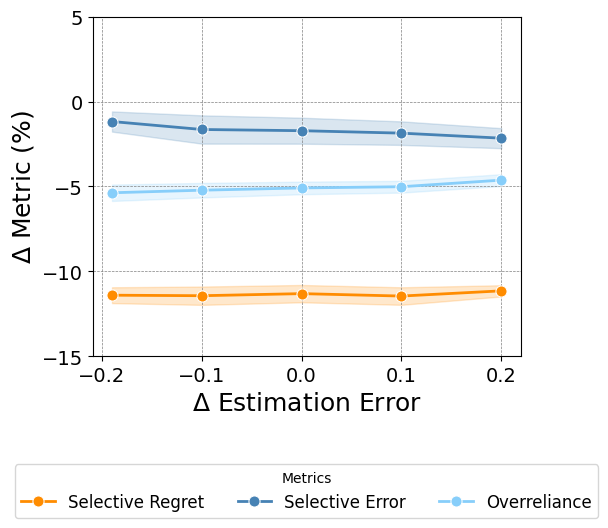

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the color palette for each metric (not for the method)
metric_colors = {
    "regret": "#FF8C00",     # Orange for Regret
    "clean_risk": "#4682B4", # Steel Blue for Clean Risk
    "fpr": "#4682B4",        # Steel Blue for FPR (False Positive Rate)
    "fnr": "#87CEFA"         # Light Blue for FNR (False Negative Rate)
}

# Define a dictionary to rename the metric labels
metric_labels = {
    "regret": "Selective Regret",
    "clean_risk": "Selective Error",
    "fpr": "False Positive Rate",
    "fnr": "Overreliance"
}

# Axis labels with delta notation
y_label = r"$\Delta$ Metric (%)"
x_label = r"$\Delta$ Estimation Error"

# Ensure 'metric' is a column in the data (preprocessed)
metrics = data['metric'].unique()

# Create a figure
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size if necessary

# Fixed abstention rate to filter
fixed_abstention_rate = 29  # Modify if necessary

# Loop through each dataset and plot the metrics
for dataset in data['dataset'].unique():
    
    # Make a local copy of the data and filter out 'fpr' safely
    dataset_data = data[(data['dataset'] == dataset) & (data['metric'] != 'fpr')].copy()

    # Capitalize first letter of the method names
    dataset_data['method'] = dataset_data['method'].str.capitalize()

    # Create abstention column, round it to the nearest integer
    dataset_data["abstention"] = (100 - dataset_data["coverage"]).round().astype(int)

    # Filter data for the specific dataset and metric of interest (Ambiguity in this case)
    sub_data = dataset_data[dataset_data["method"] == "Ambiguity"]

    # Get the baseline value (0% abstention) for each metric
    baseline_data = sub_data[sub_data['abstention'] == 0]
    baseline_regret = baseline_data.groupby(['draw_id', 'shift', 'metric'])['value'].mean().reset_index()

    # Merge baseline back into the original sub_data on draw_id, shift, and metric
    sub_data = sub_data.merge(baseline_regret, on=['draw_id', 'shift', 'metric'], suffixes=('', '_baseline'))

    # Filter data for the fixed abstention rate of interest
    sub_data = sub_data[sub_data['abstention'] == fixed_abstention_rate]

    # Calculate the delta (relative deviation) from the baseline for each metric
    sub_data['delta_value'] = sub_data['value'] - sub_data['value_baseline']

    # Use seaborn to plot with bigger dot markers for each metric
    sns.lineplot(data=sub_data, x="shift", y="delta_value", hue="metric", ax=ax,
                 linewidth=2, marker='o', markersize=8, errorbar='sd', err_style="band", markers=True,
                 dashes=False, palette=metric_colors, hue_order=["regret", "clean_risk", "fnr"])

# Set labels with delta notation
ax.set_xlabel(x_label, fontsize=18)
ax.set_ylabel(y_label, fontsize=18)

# Adjust grid and ticks to match the style
ax.grid(True, which='both', color='grey', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=14)

# Customize Y-axis limits and manually set fewer Y-ticks
ax.set_ylim([-15, 5])  # Adjust based on your data for similar scaling
ax.set_yticks([-15, -10, -5, 0, 5])  # Fewer Y-ticks for a cleaner look

# Adjust the legend: Move it below the plot
handles, labels = ax.get_legend_handles_labels()
labels = [metric_labels.get(label, label) for label in labels]  # Rename metric labels using the dict
ax.legend(handles=handles, labels=labels, loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3, fontsize=12, title="Metrics")

# Adjust the layout to make space for the legend
plt.tight_layout()
plt.savefig('/h/snagaraj/noise_multiplicity/figures/misspecify.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()